In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image

# 0. 原始影像

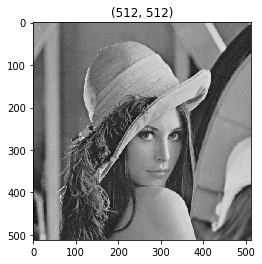

In [16]:
# 先將 lena 轉灰階

img = cv2.imread('lena_color.jpg', 1)

lena = np.array(img, dtype=np.uint8)

LenaGray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)

plt.title(LenaGray.shape)
plt.imshow(LenaGray, cmap='gray', vmin=0, vmax=255)
plt.show()

# 定義 convolution 函式

In [17]:
# 手刻 convolution 函式 (2D)

def convolution2d(image, mask):
    m, n = mask.shape
    y, x = image.shape
    y = y - m + 1
    x = x - m + 1
    new_image = np.zeros((y,x))

    for i in range(y):
        for j in range(x):
            new_image[i][j] = np.sum(image[i:i+m, j:j+m]*mask)

            if new_image[i][j] < 0:
                new_image[i][j] = 0
            
            if new_image[i][j] > 255:
                new_image[i][j] = 255

    result = np.array(new_image, dtype=np.uint8)

    # 補上沒做的邊緣像素

    result = cv2.copyMakeBorder(result, 1, 1, 1, 1, cv2.BORDER_REPLICATE)

    return result

# 1. 將原始影像銳化 > 經過 Laplacian Mask 二階微分

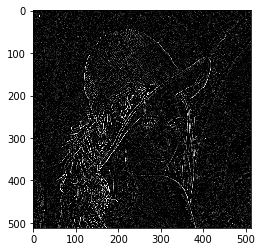

In [18]:
# Laplacian Mask consider the diagonals

laplacian = np.array((
	[-1, -1, -1],
	[-1, 8, -1],
	[-1, -1, -1]), dtype="int")

img_Laplacian = convolution2d(LenaGray, laplacian)

plt.imshow(img_Laplacian, cmap='gray', vmin=0, vmax=255)

plt.show()

# 2. 原始影像 和 Laplacian 二階微分 相加結果(有雜訊) 

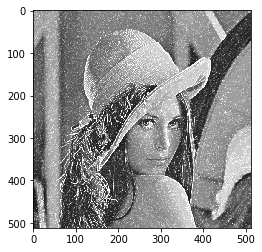

In [19]:
img_Add_Laplacian = cv2.add(LenaGray, img_Laplacian)
plt.imshow(img_Add_Laplacian, cmap='gray', vmin=0, vmax=255)
plt.show()

# 3. 原始影像做一階微分(找 Edge)

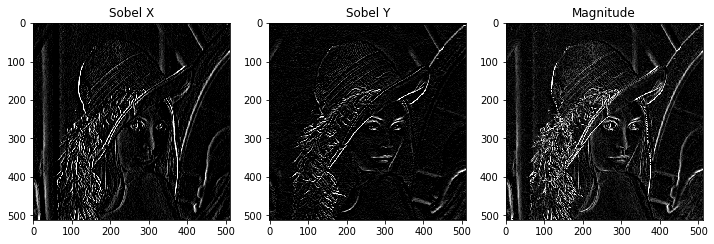

In [20]:
# construct the Sobel x-axis Mask

sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")

# construct the Sobel y-axis Mask

sobelY = np.array((
	[1, 2, 1],
	[0, 0, 0],
	[-1, -2, -1]), dtype="int")
	
plt.figure(figsize=(12, 12))

img_sobel_X = convolution2d(LenaGray, sobelX)

plt.subplot(1,3,1)
plt.title('Sobel X')
plt.imshow(img_sobel_X, cmap='gray', vmin=0, vmax=255)

img_sobel_Y = convolution2d(LenaGray, sobelY)

plt.subplot(1,3,2)
plt.title('Sobel Y')
plt.imshow(img_sobel_Y, cmap='gray', vmin=0, vmax=255)

img_magnitude = np.hypot(img_sobel_X, img_sobel_Y)
img_magnitude = np.array(img_magnitude, dtype=np.uint8)

plt.subplot(1,3,3)
plt.title('Magnitude')
plt.imshow(img_magnitude, cmap='gray', vmin=0, vmax=255)

plt.show()

# 4. 將一階微分做模糊後的結果(去雜訊)

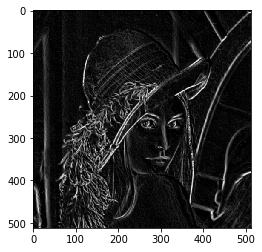

In [21]:
# 1/16 construct the Average Mask

average = np.array((
        [0.0625, 0.125, 0.0625],
        [0.125, 0.25, 0.125],
        [0.0625, 0.125, 0.0625]), dtype="float32")

img_average = convolution2d(img_magnitude, average)

plt.imshow(img_average, cmap='gray', vmin=0, vmax=255)

plt.show()

# 5. 將一階微分模糊正規化到 0-1 並乘上 (原始影像 + Laplacian 二階微分)

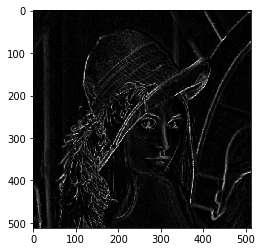

In [22]:
# normalize

img_normalized = cv2.normalize(img_average, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
edge_normalized = (img_normalized.flatten() * img_Add_Laplacian.flatten()).reshape((512, 512))
edge_normalized = np.array(edge_normalized, dtype=np.uint8)
plt.imshow(edge_normalized, cmap='gray', vmin=0, vmax=255)

# 6. 將最後加工過的二階微分 + 原始影像(無雜訊了) 

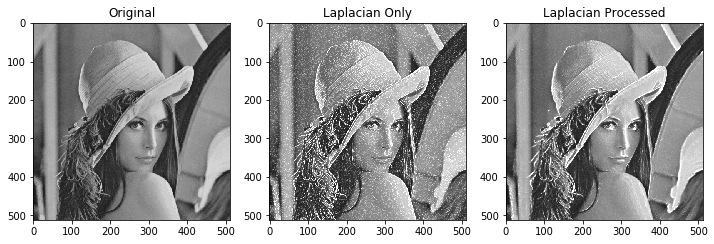

In [23]:
img_Processe_Laplacian = cv2.add(LenaGray, edge_normalized)

plt.figure(figsize=(12, 12))

plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(LenaGray, cmap='gray', vmin=0, vmax=255)

plt.subplot(1,3,2)
plt.title('Laplacian Only')
plt.imshow(img_Add_Laplacian, cmap='gray', vmin=0, vmax=255)

plt.subplot(1,3,3)
plt.title('Laplacian Processed')
plt.imshow(img_Processe_Laplacian, cmap='gray', vmin=0, vmax=255)

plt.show()